In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import glob
import pprint
import warnings
from matplotlib.patches import Rectangle
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

warnings.simplefilter('ignore')

In [2]:

matplotlib.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
# plt.rc('text.latex', preamble=r'\usepackage{lmodern}')

# Optim Result Plots
The following code was used to generate the heat maps for the real-world and synthetic data.

First the results for the different species were gathered and converted to a pandas DataFrame for plotting.

## real world data

In [3]:
df_results_overview = pd.read_csv('Results/Results_overview_arabidopsis_thaliana.csv')

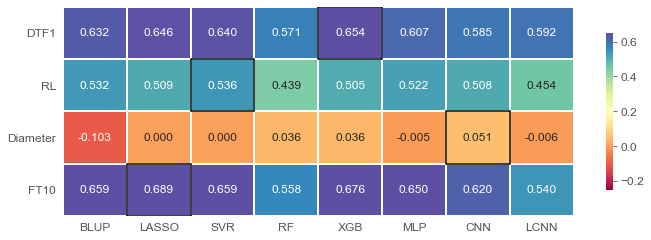

In [6]:
fig, ax = plt.subplots(figsize=(10,3.5))

plot_data = df_results_overview.filter(regex='mean').astype(float)

label_df = pd.DataFrame(columns=['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN'])
row_max = plot_data.idxmax(axis=1)
for index, row in plot_data.iterrows():
    for model in label_df.columns:
        if row_max[index] == model + '_mean':
            label_df.at[index, model] = "{:.3f}".format(row[model + '_mean'])
        else:
            label_df.at[index, model] = "{:.3f}".format(row[model + '_mean'])
sns.heatmap(data=plot_data, cmap="Spectral", cbar_kws={"shrink": .75}, vmin=-0.25, vmax=0.65,
            annot=label_df, fmt='', linewidths=1.5, linecolor='white', cbar=True, annot_kws={"size": 12})    
ax.set_xticklabels([model.split('_')[0] for model in plot_data.columns], rotation=0)
ax.set_yticklabels(df_results_overview['phenotype'], rotation=0)
ax.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=True)

for row, index in enumerate(plot_data.index):
    position = plot_data.columns.get_loc(row_max[index])
    ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='0', lw=1.5))
    
fig.tight_layout()
plt.savefig('heatmap_real_world_data.svg', bbox_inches='tight', dpi=600)
plt.show()

## simulation

In [7]:
df_results_overview = pd.read_csv('Results/Results_overview_simulated_data.csv')
# simulations
## h=0.85: 18, 16, 15, 17, 19, 39, 20, 21, 22
## h=0.7: 23, 24, 25, 26, 27, 40, 28, 29, 30
## h=0.95: 31, 32, 33, 34, 35, 41, 36, 37, 38
sim_085 = ['sim' + str(index) + '_shift' for index in [18, 16, 15, 17, 19, 39, 20, 21, 22]]
sim_07 = ['sim' + str(index) + '_shift' for index in [23, 24, 25, 26, 27, 40, 28, 29, 30]]
sim_095 = ['sim' + str(index) + '_shift' for index in [31, 32, 33, 34, 35, 41, 36, 37, 38]]

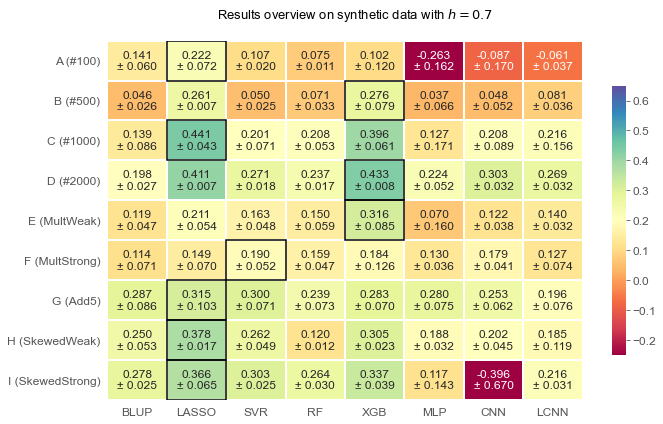

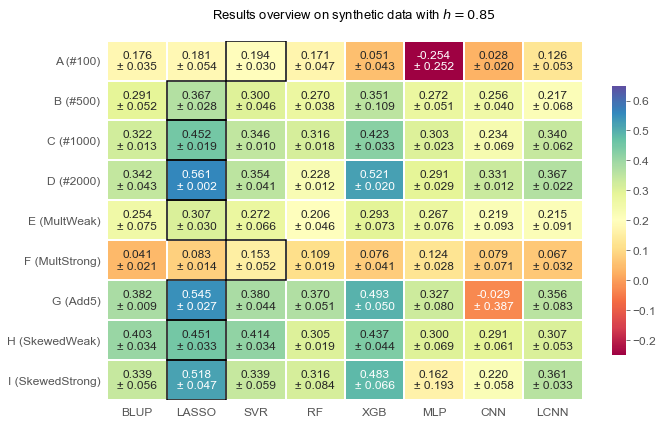

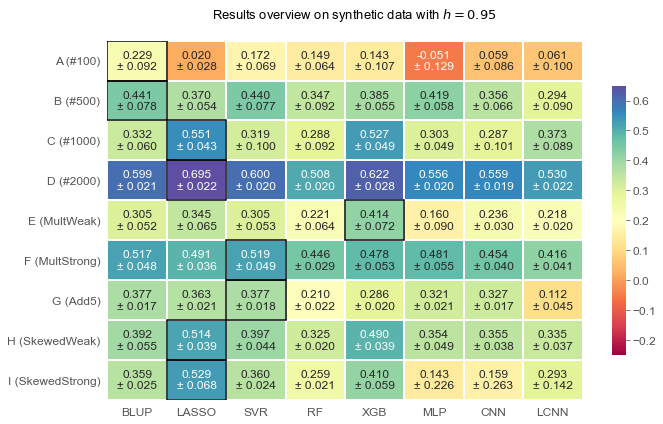

In [8]:
for sim_config, number in zip([sim_07, sim_085, sim_095], ['07', '085', '095']):
    df_config = df_results_overview[df_results_overview['phenotype'].isin(sim_config)]
    df_config = df_config.set_index('phenotype').loc[sim_config]
    df_config.loc[:, 'phenotype'] = ['A' + ' (#100)',
                                     'B' + ' (#500)', 
                                     'C' + ' (#1000)', 
                                     'D' + ' (#2000)',
                                     'E' + ' (MultWeak)', 
                                     'F' + ' (MultStrong)', 
                                     'G' + ' (Add5)', 
                                     'H' + ' (SkewedWeak)', 
                                     'I' + ' (SkewedStrong)']
    df_config.reset_index(inplace=True, drop=True)
    label_df = pd.DataFrame(columns=['BLUP', 'LASSO', 'SVR', 'RF', 'XGB', 'MLP', 'CNN', 'LCNN'])
    for index, row in df_config.iterrows():
        for model in label_df.columns:
            label_df.at[index, model] = \
                "{:.3f}".format(row[model + '_mean']) + "\n\u00B1 {:.3f}".format(row[model + '_std'])
    
    fig, ax = plt.subplots(figsize=(10,6))

    plot_data = df_config.filter(regex='mean').astype(float)
    
    # We use ax parameter to tell seaborn which subplot to use for this plot
    sns.heatmap(data=plot_data, cmap="Spectral", cbar_kws={"shrink": .75}, vmin=-0.25, vmax=0.65,
                annot=label_df, fmt='', linewidths=1.5, linecolor='white', cbar=True, annot_kws={"size": 12, "ha": "center"})
    ax.set_xticklabels([model.split('_')[0] for model in plot_data.columns], rotation=0)
    ax.set_yticklabels(df_config['phenotype'], rotation=0)
    ax.tick_params(top=False,
                   bottom=False,
                   left=False,
                   right=False,
                   labelleft=True,
                   labelbottom=True)
    row_max = plot_data.idxmax(axis=1)
    for row, index in enumerate(plot_data.index):
        position = plot_data.columns.get_loc(row_max[index])
        ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='0', lw=1.5))
    h = '0.' + str(number.split('0')[1])
    fig.suptitle('Results overview on synthetic data with '+ r'$\mathit{h=' + h + '}$', fontsize=13)
    fig.tight_layout()
    plt.savefig('heatmap_sim_' + number + '.pdf', bbox_inches='tight', dpi=600)
    plt.show()

# Feat Importance Analyse

## Real-world data (feat importances vs GWAS results)

In [19]:
# generate data for Venn diagrams 
data = {}
phenotypes = ['DTF1', 'RL', 'Diameter', 'FT10']
species = 'Ara'
for pheno in phenotypes:
    # load data
    lin=f'Results/{pheno}_linearregression_feature_importances.csv'
    xgb=f'Results/{pheno}_xgboost_feature_importances.csv'
    rf=f'Results/{pheno}_RF_feature_importances.csv'
    gwas_data=f'GWAS_results/ld_pruned_gwas_results_{pheno}.csv'
    df_lin = pd.read_csv(lin)
    df_lin=df_lin.drop(df_lin[df_lin.coefficients_0 ==0].index)
    df_xgb = pd.read_csv(xgb)
    df_xgb = df_xgb.drop(df_xgb[df_xgb.feat_importance_standard ==0].index)
    df_rf = pd.read_csv(rf)
    df_rf = df_rf.drop(df_rf[df_rf.feat_importance_standard ==0].index)
    df_gwas = pd.read_csv(gwas_data)
    df_gwas = df_gwas.nsmallest(1000, 'p_value')
    snp_ids=[]
    for i in range(len(df_gwas['CHR'])):
        snp_ids.append(str(df_gwas['POS'][i])+"_"+str(df_gwas['CHR'][i]))
    
    # compute all intersections
    set_lin = set(df_lin['snp_ids_0'])
    set_xgb = set(df_xgb['snp_ids_standard'])
    set_rf = set(df_rf['snp_ids_standard'])
    set_gwas100 = set(snp_ids)

    int_all = set.intersection(set_lin, set_xgb, set_rf)
    int_lin_xgb = set.intersection(set_lin, set_xgb)
    int_lin_rf = set.intersection(set_lin, set_rf)
    int_rf_xgb = set.intersection(set_rf, set_xgb)

    top100_all = set.intersection(int_all,  set_gwas100)
    top100_lin_xgb = set.intersection(int_lin_xgb,  set_gwas100)
    top100_lin_rf = set.intersection(int_lin_rf,  set_gwas100)
    top100_rf_xgb = set.intersection(int_rf_xgb,  set_gwas100)
    top100_lin = set.intersection(set_lin, set_gwas100)
    top100_xgb = set.intersection(set_xgb, set_gwas100)
    top100_rf = set.intersection(set_rf, set_gwas100)
    
    # generate list with data in right order for Venn diagram
    part = [0]*7
    part_top = [0]*7
    part[6] = len(int_all)
    part_top[6] = len(top100_all)
    part[5] = len(int_rf_xgb)-part[6]
    part_top[5] = len(top100_rf_xgb)-part_top[6]
    part[4] = len(int_lin_rf)-part[6]
    part_top[4] = len(top100_lin_rf)-part_top[6]
    part[3] = len(set_rf)-part[4]-part[5]-part[6]
    part_top[3] = len(top100_rf)-part_top[4]-part_top[5]-part_top[6]
    part[2] = len(int_lin_xgb)-part[6]
    part_top[2] = len(top100_lin_xgb)-part_top[6]
    part[1] = len(set_xgb)-part[2]-part[6]-part[5]
    part_top[1] = len(top100_xgb)-part_top[2]-part_top[6]-part_top[5]
    part[0] = len(set_lin)-part[2]-part[6]-part[4]
    part_top[0] = len(top100_lin)-part_top[2]-part_top[6]-part_top[4]

    numbers = []
    for i in range(7):
        numbers.append(str(part[i])+'('+str(part_top[i])+')')
        
    data[f'{species}_{pheno}'] = numbers

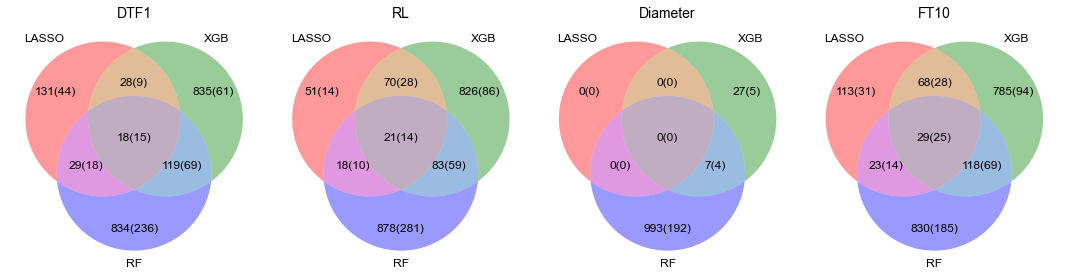

In [25]:
#create plot
titles = [
    'DTF1',
    'RL', 
    'Diameter', 
    'FT10'
]

names = ['Ara_DTF1', 'Ara_RL', 'Ara_Diameter', 'Ara_FT10']

fig = plt.figure(figsize=(15, 5))

for i in range(len(names)):
        ax = fig.add_subplot(1, 4, i+1)
        v = venn3_unweighted(subsets=data[names[i]], set_labels=('LASSO', 'XGB', 'RF'), ax=ax)
        for text in v.set_labels:
           text.set_fontsize(12)
        for text in v.subset_labels:
           text.set_fontsize(12)
        ax.set_title(titles[i], fontsize=14)
plt.subplots_adjust(hspace=0.1)
#fig.suptitle('Feature importances compared with GWAS results', fontsize=14)
fig.tight_layout()
plt.savefig('Venn_diagram.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Synthetic data (feat importances vs. effect sizes)

The following code can be used to analyze the feature importance of LASSO, XGB and RF in comparison with the effect sizes of all simulated scenarios. Furthermore, the code for generating the scatter plots is included.

In [13]:
all_sim_configs = pd.read_csv('Simulations/Simulation_configs_gathered.csv')
all_feat_imps = pd.read_csv('Results/Feature_importances_all_simulations.csv')

In [14]:
stats = pd.DataFrame(
    columns=['sim_id', 'model', '#features_with_imp', '#detected_background_snps', '#background_snps', 'ratio_background_detected', 'ratio_background_detected_by_feat_imp',
             '#detected_causal_snps', '#causal_snps', 'ratio_causal_detected', 'causal_snps_detected', 'featimp_rank_causal_snps'])
for sim_id in set(all_sim_configs.sim_id):
    config_simid = all_sim_configs[all_sim_configs.sim_id == sim_id]
    feat_imp_simid = all_feat_imps[all_feat_imps.sim_id == sim_id]
    for model in set(feat_imp_simid.model):
        new_row = {}
        new_row['sim_id'] = sim_id
        new_row['model'] = model
        feat_imp_model = feat_imp_simid[feat_imp_simid.model == model]
        non_zero_featimps = feat_imp_model[feat_imp_model.feat_imp != 0.0]
        new_row['#features_with_imp'] = non_zero_featimps.shape[0]
        background = config_simid[config_simid.type == 'background']
        causal = config_simid[config_simid.type=='causal']
        new_row['#detected_background_snps'] = len(set(non_zero_featimps.snp_id).intersection(set(background.snp_id)))
        new_row['#background_snps'] = len(set(background.snp_id))
        new_row['ratio_background_detected_by_feat_imp'] = round(new_row['#detected_background_snps'] / new_row['#features_with_imp'], 2) if new_row['#features_with_imp'] != 0 else np.nan
        new_row['ratio_background_detected'] = round(new_row['#detected_background_snps'] / new_row['#background_snps'], 2)
        new_row['#detected_causal_snps'] = len(set(non_zero_featimps.snp_id).intersection(set(causal.snp_id)))
        new_row['#causal_snps'] = len(set(causal.snp_id))
        new_row['ratio_causal_detected'] = round(new_row['#detected_causal_snps'] / new_row['#causal_snps'], 2)
        new_row['causal_snps_detected'] = 'Yes' if new_row['ratio_causal_detected'] == 1 else 'No'
        featimp_sorted = non_zero_featimps.sort_values(by='feat_imp', ascending=False).reset_index(drop=True)
        new_row['featimp_rank_causal_snps'] = list(featimp_sorted[featimp_sorted.snp_id.isin(set(causal.snp_id))].index + 1)
        stats = stats.append(new_row, ignore_index=True)
stats = stats.sort_values(by=['sim_id', 'model'])

In [15]:
stats
stats.to_csv('Simulated_data_statistics_beta_vs_featimp.csv')

In [16]:
sim_085 = ['sim' + str(index) for index in [18, 16, 15, 17, 19, 39, 20, 21, 22]]
sim_07 = ['sim' + str(index) for index in [23, 24, 25, 26, 27, 40, 28, 29, 30]]
sim_095 = ['sim' + str(index) for index in [31, 32, 33, 34, 35, 41, 36, 37, 38]]

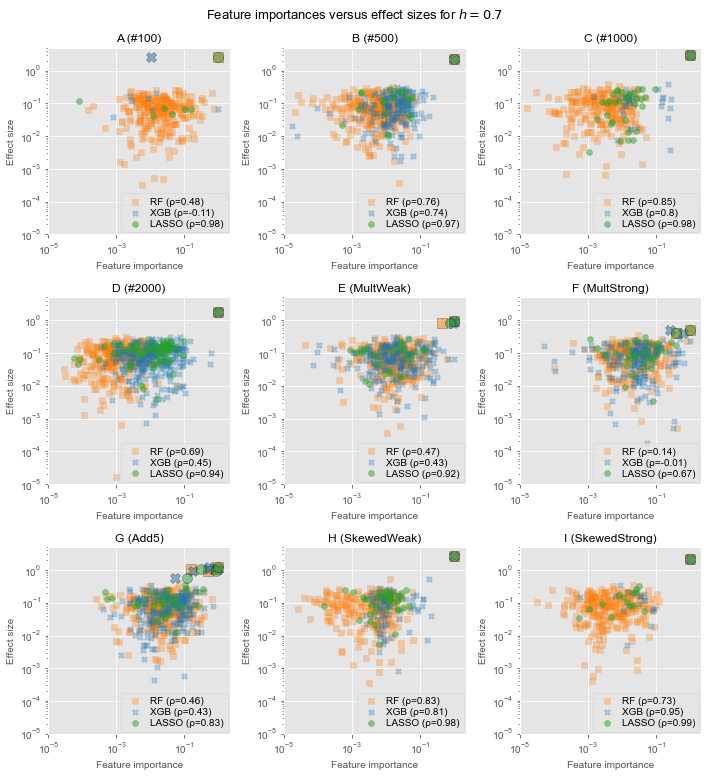

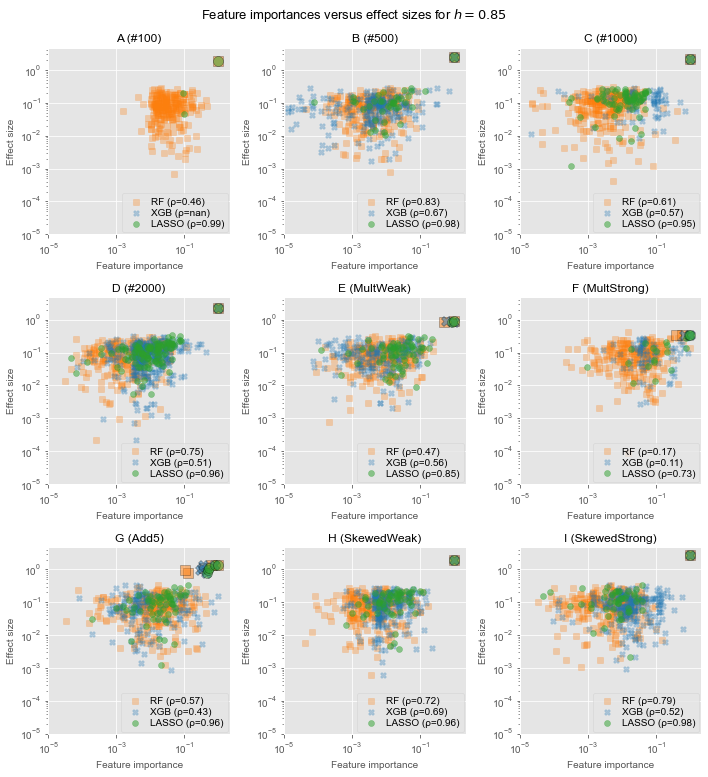

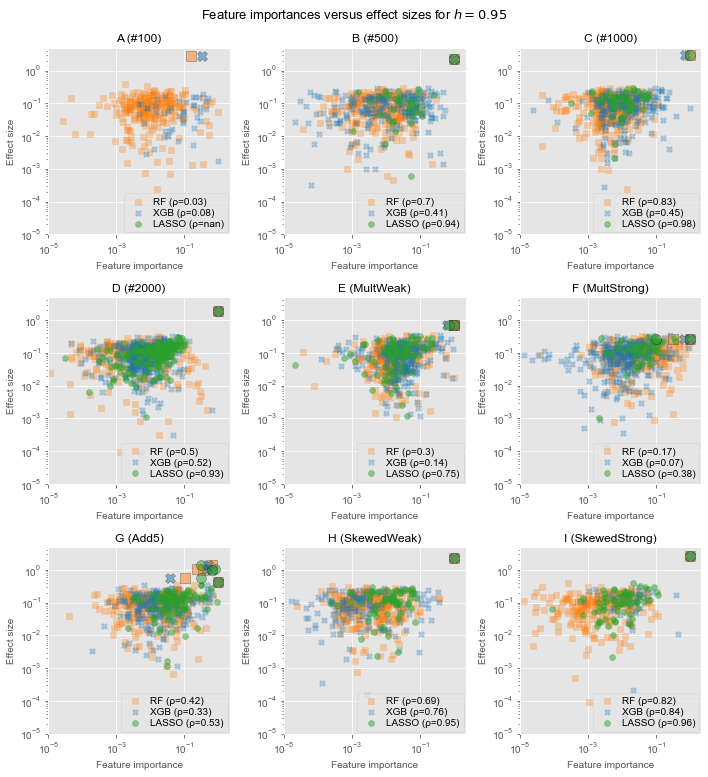

In [17]:
titles = [
    'A' + ' (#100)',
    'B' + ' (#500)', 
    'C' + ' (#1000)', 
    'D' + ' (#2000)',
    'E' + ' (MultWeak)', 
    'F' + ' (MultStrong)', 
    'G' + ' (Add5)', 
    'H' + ' (SkewedWeak)', 
    'I' + ' (SkewedStrong)'
]

for sim_config, number in zip([sim_07, sim_085, sim_095], ['07', '085', '095']):
    fig = plt.figure(figsize=(10, 11))
    sim_info = all_sim_configs[all_sim_configs['sim_id'].isin(sim_config)]
    feat_info = all_feat_imps[all_feat_imps['sim_id'].isin(sim_config)]
    
    beta_max = sim_info[sim_info['beta']!= 0]['beta'].astype(float).abs().max()
    feat_imp_max = feat_info[feat_info['feat_imp']!=0]['feat_imp'].astype(float).abs().max()
    beta_min = sim_info[sim_info['beta']!= 0]['beta'].astype(float).abs().min()
    feat_imp_min = feat_info[feat_info['feat_imp']!=0]['feat_imp'].astype(float).abs().min()
    for plot_nr, sim_id in enumerate(sim_config):
        ax = fig.add_subplot(3, 3, plot_nr+1)
        sim_info_for_id = sim_info[sim_info['sim_id'] == sim_id]
        feat_info_for_id = feat_info[feat_info['sim_id'] == sim_id]
        for model in ['randomforest', 'xgboost', 'linearregression']: # delete other two list items to generate plot for one
            feat_info_for_model = feat_info_for_id[feat_info_for_id['model'] == model]
            plot_info = sim_info_for_id.iloc[:, 1:].join(feat_info_for_model.iloc[:, 2:].set_index('snp_id'), on=['snp_id']).fillna(0)
            plot_info_non_zero = plot_info[plot_info['feat_imp'] != 0]
            corr = np.corrcoef(plot_info_non_zero['beta'].astype(float), plot_info_non_zero['feat_imp'].astype(float))[0][1]
            plot_info_non_zero['beta'] = plot_info_non_zero['beta'].astype(float).abs()
            plot_info_non_zero['feat_imp'] = plot_info_non_zero['feat_imp'].astype(float).abs()
            plot_info_non_zero['feat_imp'] = (plot_info_non_zero['feat_imp']-plot_info_non_zero['feat_imp'].min()) / (plot_info_non_zero['feat_imp'].max()-plot_info_non_zero['feat_imp'].min())
            plot_info_background = plot_info_non_zero[plot_info_non_zero['type'] == 'background']
            plot_info_causal = plot_info_non_zero[plot_info_non_zero['type'] == 'causal']
            if model == 'xgboost':
                marker = 'X'
                alpha_offset = 0  # 0 if all are plotted #0.2 for single
                c = 'tab:blue'
                label = 'XGB'
            elif model == 'randomforest':
                marker = 's'
                alpha_offset=0    #0 if all are plotted #0.2 for single
                c = 'tab:orange'
                label = 'RF'
            elif model =='linearregression':
                marker = 'o'
                alpha_offset=0.2
                c = 'tab:green'
                label='LASSO'
            ax.scatter(x=plot_info_background['feat_imp'], y=plot_info_background['beta'], marker=marker, c=c, alpha=0.3+alpha_offset, label=label + ' (\u03C1=' + str(round(corr, 2)) +')')
            ax.scatter(x=plot_info_causal['feat_imp'], y=plot_info_causal['beta'], marker=marker, c=c, s=100, alpha=0.5,    #0.5 if all are plotted #0.7 for single
                       label='_nolegend_', edgecolors='black')
        ax.set(xscale="log", yscale="log")
        ax.set_xlim(0.00001, 1 + np.exp(0.2))
        ax.set_ylim(0.00001, beta_max+2) #+np.exp(0.1)) #+np.exp(0.7))
        ax.set_xlabel('Feature importance', fontsize=10)
        ax.set_ylabel('Effect size', fontsize=10)
        ax.set_title(titles[plot_nr], fontsize=12)
        ax.legend(loc='lower right', fontsize=10, labelspacing=0.2, handletextpad=0.5, borderaxespad=0.2)
        ax.tick_params(labelsize=10)
    plt.subplots_adjust(hspace=0.1)
    h = '0.' + str(number.split('0')[1])
    fig.suptitle('Feature importances versus effect sizes for '+ r'$\mathit{h=' + h + '}$', fontsize=13)
    fig.tight_layout()
    plt.savefig('scatterplot_all_' + number + '.pdf', bbox_inches='tight', dpi=300) # change name if you generate plots for only one
    plt.show()

# Dataset Analysis for *A. thaliana*

With the following code, one can generate the histograms shown in the Supplementary.

In [ ]:
# CATUION: These files are not included in our GitHub repository and can be found here: https://arapheno.1001genomes.org/

Ara_12 = pd.read_csv('study_12_values.csv') #FT10
Ara_38 = pd.read_csv('study_38_values.csv') #DTF1, RL, Diameter

In [ ]:

titles = [
    '$\it{A. thaliana}$' + ' DTF1',
    '$\it{A. thaliana}$' + ' RL', 
    '$\it{A. thaliana}$' + ' Diameter', 
    '$\it{A. thaliana}$' + ' FT10',
]
data = [Ara_38, Ara_38, Ara_38, Ara_12]
pheno = ['DTF1', 'RL', 'Diameter', 'FT10']

fig = plt.figure(figsize=(10, 11))

for i in range(len(data)):
        shapiro_test = stats.shapiro(data[i][pheno[i]].dropna())
        p = shapiro_test.pvalue
        ax = fig.add_subplot(1, 4, i+1)
        sns.histplot(data = data[i],x = pheno[i], ax=ax ,color = 'green',alpha = 1)
        ax.set_xlabel('Value', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.set_title(titles[i], fontsize=12)
        ax.tick_params(labelsize=10)
        if p < 0.05:
            text = 'p = ' + str("{:.2e}".format(p)) + ' *'
        else:
            text = 'p = ' + str("{:.2e}".format(p))
        ax.text(0.645, 0.96,s=text, fontsize=10, transform=ax.transAxes)
plt.subplots_adjust(hspace=0.1)
#fig.suptitle('Distribution of phenotypes', fontsize=13)
fig.tight_layout()
plt.savefig('histogram.svg', bbox_inches='tight', dpi=300)
plt.savefig('histogram.jpg', bbox_inches='tight', dpi=300)
plt.savefig('histogram.pdf', bbox_inches='tight', dpi=300)
plt.show()